## CML logistic sanity checks
These cells preview the updated generator (minimum lattice size 20, cropped to requested M) before running the PBS array.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.generate import generate_cml_logistic
from src.plot_style import apply_plot_style
from src.mapping import ExperimentConfig, DatasetMapping

apply_plot_style()
sns.set_style('white')

def preview_cml_grid(
    Ms,
    deltas,
    T=400,
    seed=0,
    *,
    config_path=None,
    mts_class=None,
    variant_name=None,
    instance=0,
    **params,
):
    """
    Generates one CML trajectory per M and plots stride-based views.
    If a config/class/variant are provided, cached cluster datasets are loaded
    so the plots mirror the production pipeline exactly.
    """
    n_rows = len(Ms)
    n_cols = len(deltas)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 2.5 * n_rows),
        squeeze=False,
        sharex='col',
        constrained_layout=True,
    )

    results = {}
    seeds_per_M: dict[int, int]
    if seed is None:
        master_rng = np.random.default_rng()
        seeds_per_M = {M: int(master_rng.integers(0, 2**32 - 1, dtype=np.uint32)) for M in Ms}
    else:
        seeds_per_M = {M: int(seed) for M in Ms}

    cluster_series: dict[int, np.ndarray] = {}
    if config_path and mts_class:
        config = ExperimentConfig.from_file(config_path)
        mapping = DatasetMapping(config)
        for spec in mapping.specs:
            if spec.mts_class != mts_class:
                continue
            if spec.M not in Ms or spec.T != T or spec.instance != instance:
                continue
            spec_variant = spec.variant.name if spec.variant else None
            if variant_name is None and spec_variant is not None:
                continue
            if variant_name is not None and spec_variant != variant_name:
                continue
            ts_path = spec.dataset_dir / "arrays" / "timeseries.npy"
            if ts_path.exists():
                cluster_series[spec.M] = np.load(ts_path)

    data_by_M: dict[int, np.ndarray] = {}
    for M in Ms:
        if M in cluster_series:
            data_by_M[M] = cluster_series[M]
            continue
        rng = np.random.default_rng(seeds_per_M[M])
        data_by_M[M] = generate_cml_logistic(
            M=M,
            T=T,
            rng=rng,
            **params,
        )

    for i, M in enumerate(Ms):
        base_series = data_by_M[M]
        for j, delta in enumerate(deltas):
            ax = axes[i, j]
            stride = max(1, int(delta))
            view = base_series if stride == 1 else base_series[::stride]
            results[(M, stride)] = view

            ax.pcolormesh(
                view.T,
                cmap=sns.color_palette('icefire', as_cmap=True),
                vmin=-2,
                vmax=2,
            )

            # if i == 0:
                # ax.set_title(f"$\u03b4={stride}$", fontsize=12, fontweight='bold')
            if j == 0:
                ax.set_ylabel(f"$M={M}$", fontsize=12, fontweight='bold')

            if i < n_rows - 1:
                ax.tick_params(labelbottom=False)
            if j > 0:
                ax.tick_params(labelleft=False)

    fig.supxlabel("Time steps (after stride)")
    plt.show()
    return results


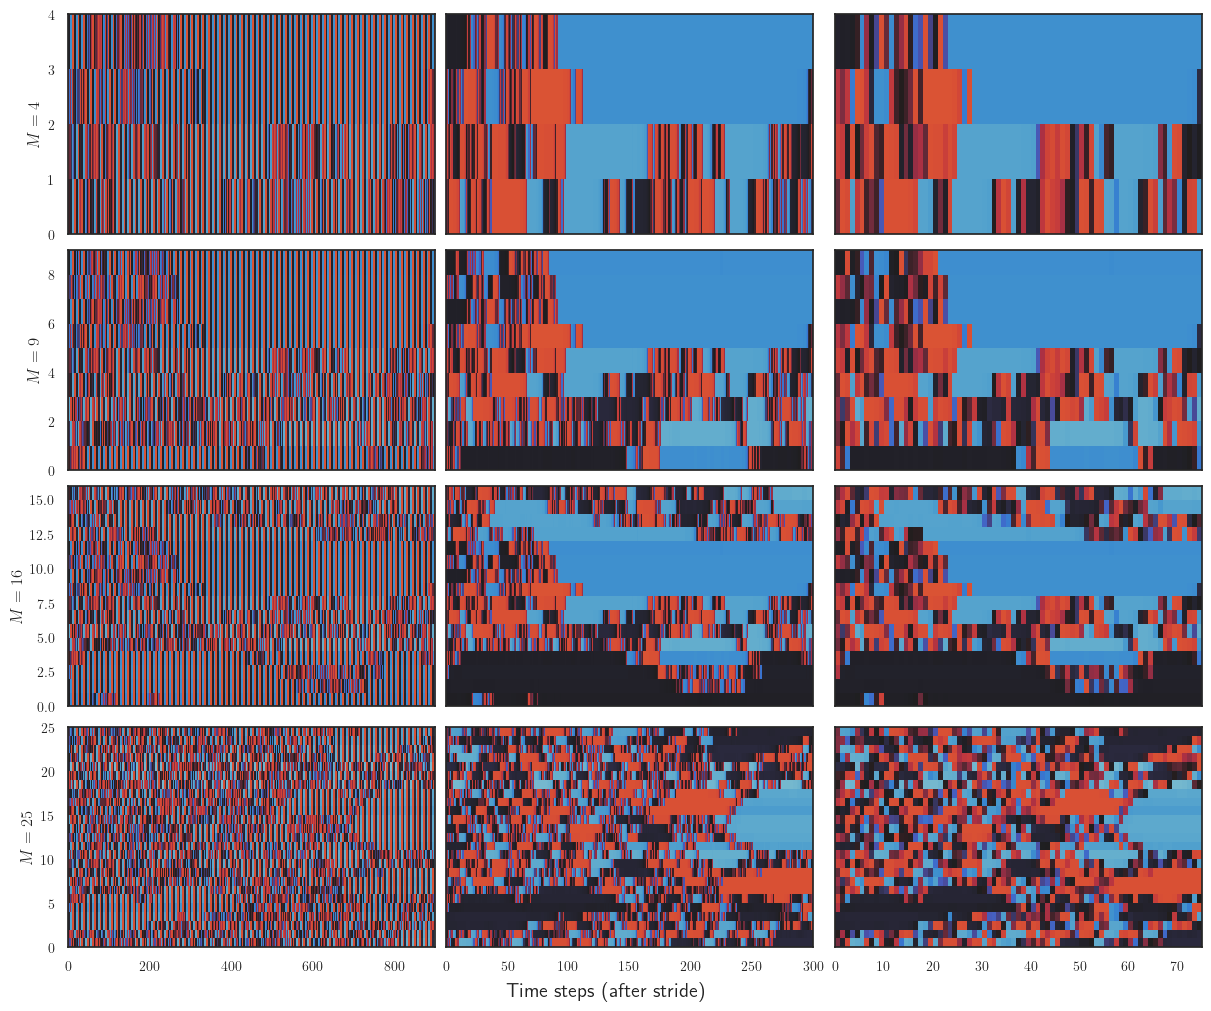

In [5]:
grid = preview_cml_grid(
    Ms=[4, 9, 16, 25],
    deltas=[1,3,12],
    T=900,
    config_path="configs/experiments_full_2.yaml",
    mts_class="CML",
    variant_name="spatiotemporal_intermittency_I",
    instance=0,
)

# CML + Kuramoto Toy Demo

Use the project generators to synthesise STI-I CML and Kuramoto datasets, then visualise them with the same heatmap style used in the pipeline.

In [6]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [7]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.generate as gen_mod
importlib.reload(gen_mod)
from src.generate import generate_cml_logistic, generate_kuramoto, generate_wave_1d, generate_wave_2d
from src.plot_style import apply_plot_style

def plot_heatmap(data, title):
    apply_plot_style()
    plt.figure(figsize=(10, 3))
    sns.heatmap(
        data.T,
        cmap=sns.color_palette('icefire', as_cmap=True),
        vmin=-2,
        vmax=2,
        cbar=False,
        xticklabels=False,
        yticklabels=False,
    )
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Channel')
    plt.show()


### Wave-equation parameter sets
Using the Brain Dynamics Toolkit description (wave speed $c=10$, Gaussian initial conditions with $\sigma=M/20$, periodic boundaries), the following combinations reproduce the typical textures:
- $M=9, T=100$ (short checkerboard).
- $M=16, T=500$ (zig-zag reflections).
- $M=25, T=1000$ (dense interference lattice).
We discretise a unit domain with spatial step $\Delta x = 1/M$ and choose $\Delta t = 0.3\Delta x / c$ for stability.

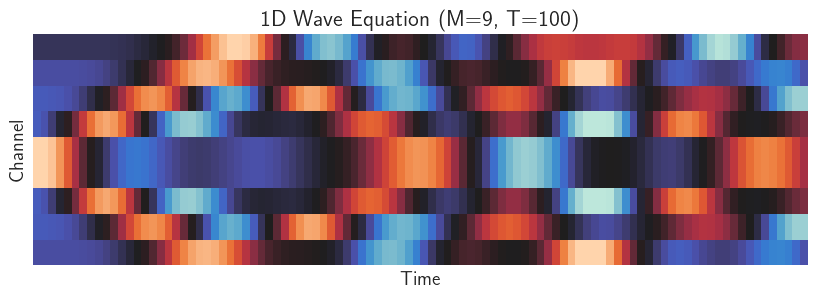

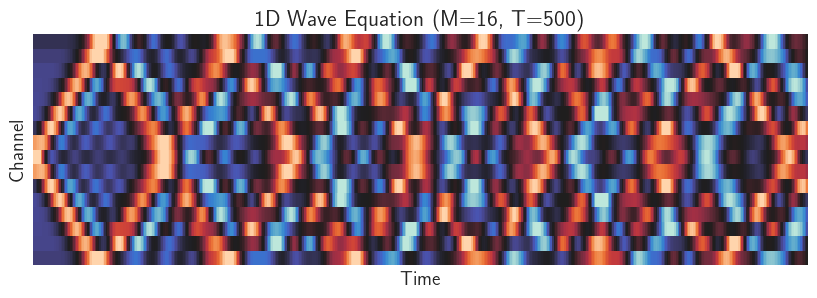

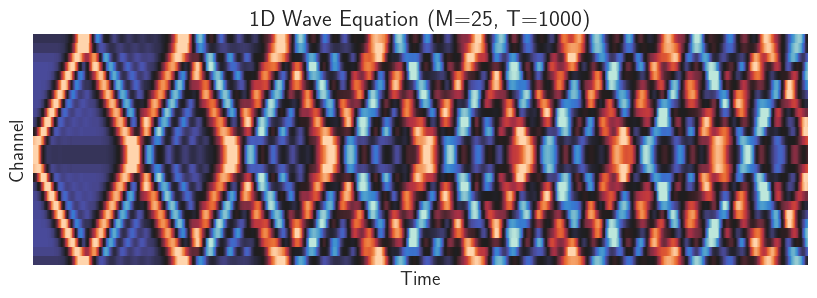

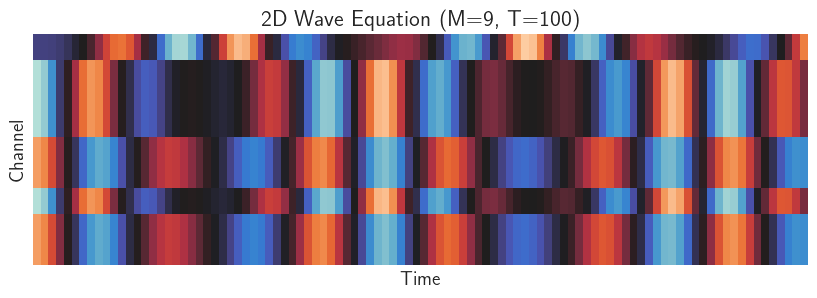

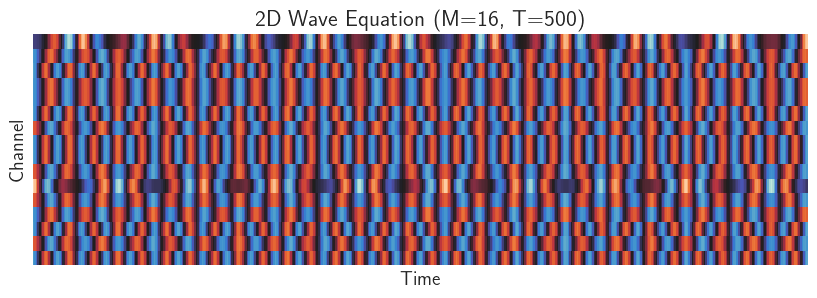

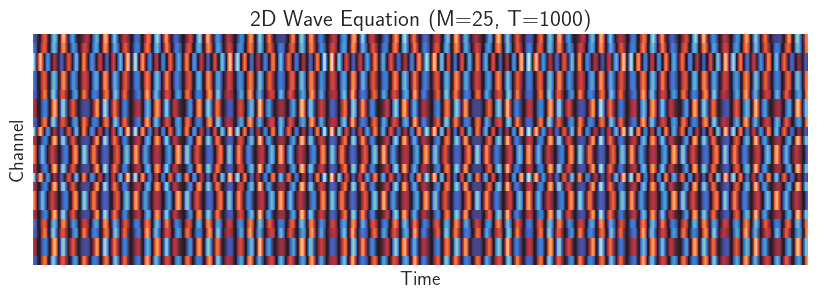

In [8]:
for M, T in [(9, 100), (16, 500), (25, 1000)]:
    wave1d = generate_wave_1d(M=M, T=T)
    plot_heatmap(wave1d, f'1D Wave Equation (M={M}, T={T})')

for M, T in [(9, 100), (16, 500), (25, 1000)]:
    wave2d = generate_wave_2d(M=M, T=T)
    plot_heatmap(wave2d, f'2D Wave Equation (M={M}, T={T})')


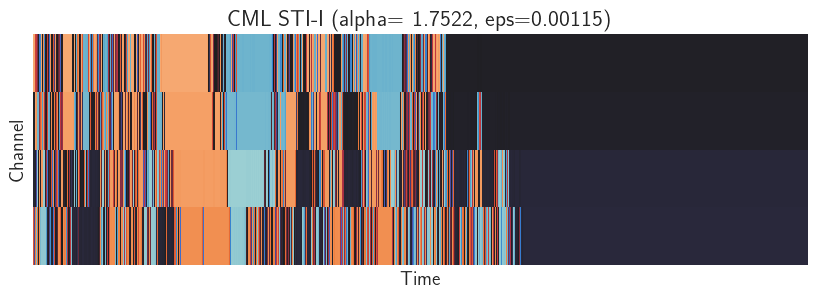

In [9]:
cml_rng = np.random.default_rng(52025)
cml_params = dict(M=4, T=1250, alpha=1.7522, eps=0.00115, delta=12)
cml_data = generate_cml_logistic(rng=cml_rng, **cml_params)
plot_heatmap(cml_data, f"CML STI-I (alpha= {cml_params['alpha']}, eps={cml_params['eps']})")


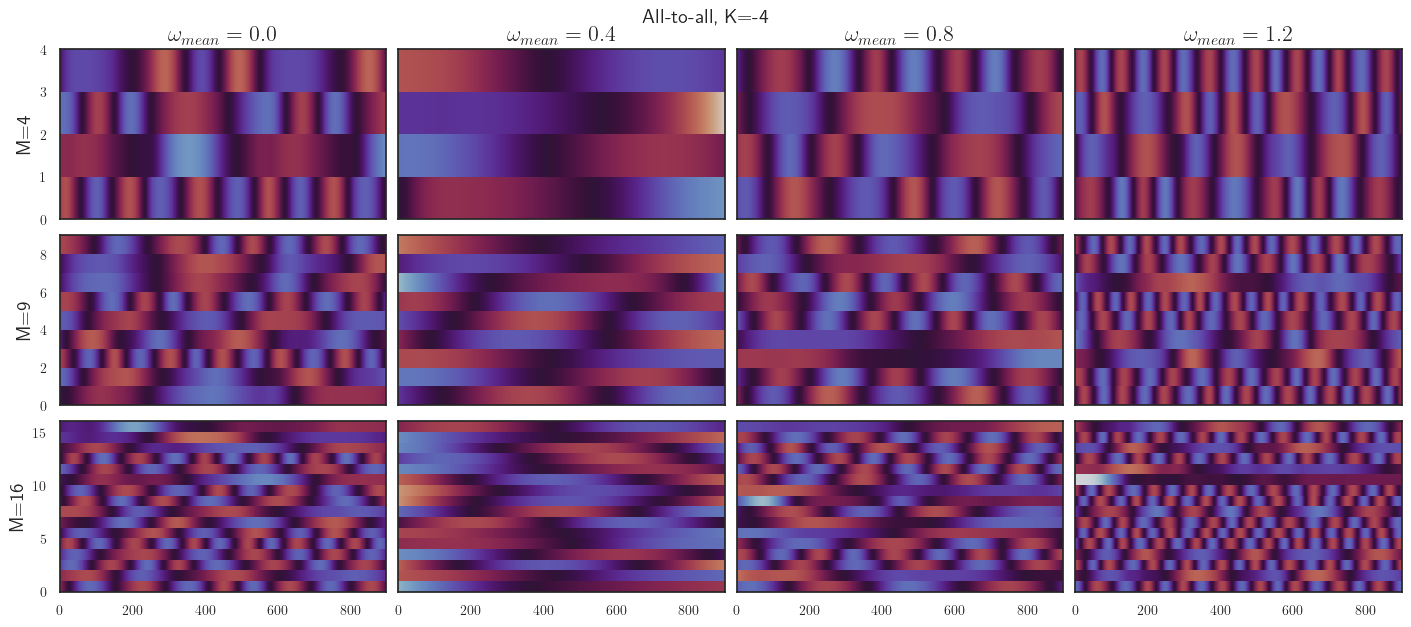

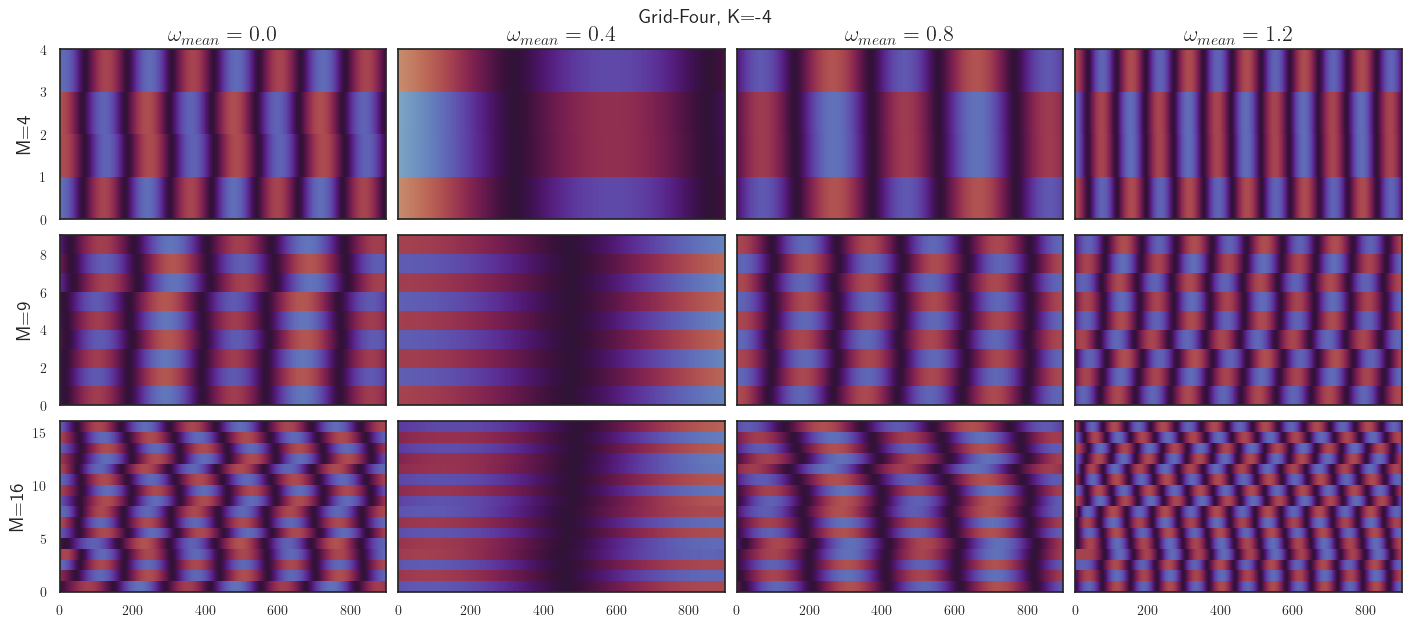

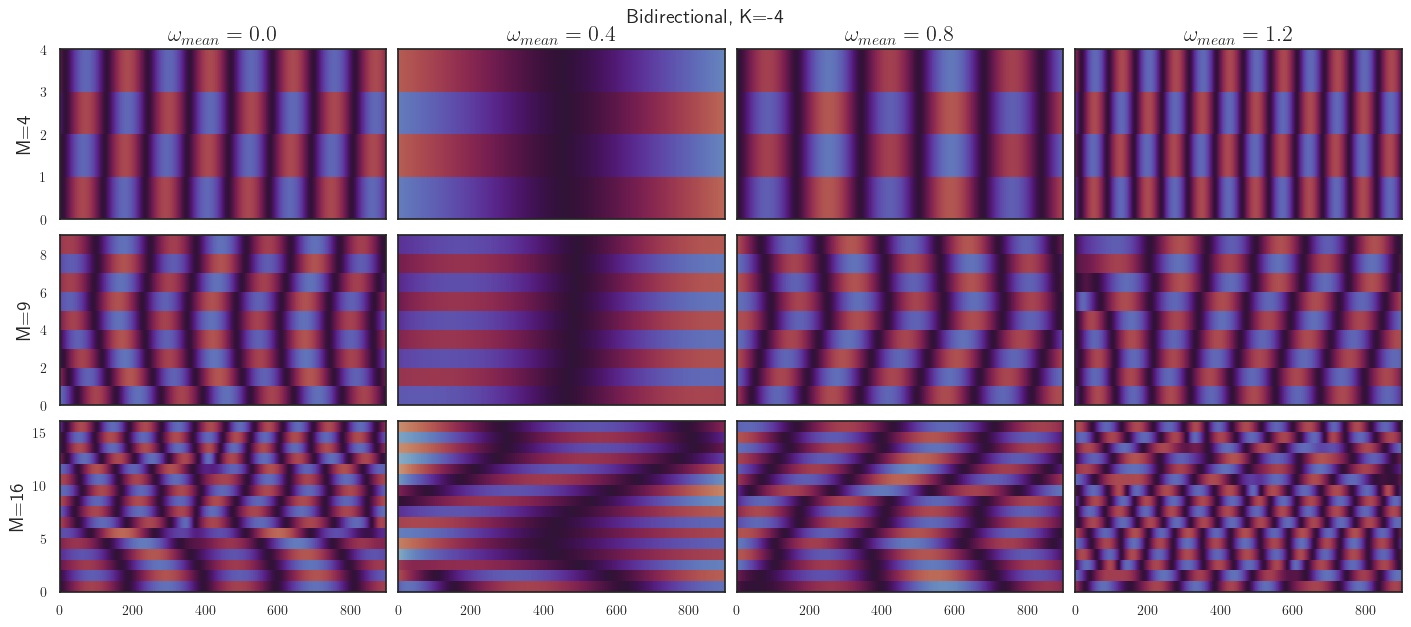

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sweep Parameters
Ms_sweep = [4, 9, 16]
omega_means_sweep = [0.0, 0.4, 0.8, 1.2] # Varying natural frequency mean

demo_configs = [
    dict(label="All-to-all, K=-4", kwargs=dict(k=-4, connectivity="all-to-all")),
    dict(label="Grid-Four, K=-4",  kwargs=dict(k=-4, connectivity="grid-four")),
    dict(label="Bidirectional, K=-4", kwargs=dict(k=-4, connectivity="bidirectional-list")),
]

# Fixed parameters (dt=0.1 defined here)
base_kwargs = dict(T=900, dt=0.10, transients=100, eta=0.0)

for cfg in demo_configs:
    n_rows, n_cols = len(Ms_sweep), len(omega_means_sweep)
    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(3.5 * n_cols, 2 * n_rows), 
        squeeze=False, sharex='col', constrained_layout=True
    )
    fig.suptitle(cfg['label'], fontweight='bold', y=1.02)

    for i, M in enumerate(Ms_sweep):
        for j, mean in enumerate(omega_means_sweep):
            ax = axes[i, j]
            
            # Reset RNG for valid comparison
            rng = np.random.default_rng(5)
            
            series = generate_kuramoto(
                rng=rng, 
                omega_mean=mean, # Sweeping parameter
                omega_std=0.6,   # Fixed parameter
                M=M, 
                **base_kwargs, 
                **cfg['kwargs']
            )

            # Reverted to twilight for correct cyclic phase visualization
            ax.pcolormesh(
                series.T, 
                cmap='icefire', 
                vmin=-2, vmax=2
            )

            if i == 0: ax.set_title(f"$\omega_{{mean}}={mean}$")
            if j == 0: ax.set_ylabel(f"M={M}")
            
            if i < n_rows - 1: ax.tick_params(labelbottom=False)
            if j > 0: ax.tick_params(labelleft=False)
            
    plt.show()

### SVG heatmap check
Generated via the updated pipeline; loading the vector graphic directly ensures the LaTeX font renders inside the notebook.
